### Анализ эффективности маркетинговых кампаний в e-commerce

### Описание данных

В рамках проекта выполнена симуляция пользовательского поведения и маркетинговых кампаний e-commerce платформы (Яндекс Лавка) для проведения A/B-теста и анализа эффективности.

#### Пользователи (`user_df`)
- Общее количество пользователей: **5 000**
- География: Москва, Санкт-Петербург, Казань, Новосибирск, Екатеринбург
- Платформы: **iOS** и **Android**
- Типы пользователей по активности:
  - `active` – высокоактивные
  - `medium` – умеренно активные
  - `rare` – редко возвращающиеся

#### События в приложении (`events_df`)
- Период наблюдения: **01.02.2024 – 31.05.2024**
- Симулировано поведение пользователей в приложении с вероятностями переходов:
  - Основные события: `open_app`, `search`, `view_product`, `add_to_cart`, `pay_page`, `finish_pay`
  - Дополнительно: `abandon_cart`, `remove_from_cart`, `apply_coupon`, `like`, `scroll_page`
- Для тестовой группы увеличена вероятность покупки (`finish_pay`)

#### Маркетинговые кампании (`campaigns_df`)
| Campaign ID              | Тип     | Канал  | Цель                        | Период              |
|--------------------------|---------|--------|-----------------------------|----------------------|
| `push_abandon_cart`      | Push    | Push   | Возврат после брошенной корзины | 05.02–19.02.2024 |
| `email_weekly_newsletter`| Email   | Email  | Повышение вовлечённости     | 01.03–01.04.2024     |
| `push_delivery_discount` | Push    | Push   | Продвижение доставки        | 20.02–27.02.2024     |

#### A/B тест (`campaign_interactions_df`, `control_group_df`)
- Кампания **`push_abandon_cart`** является основным объектом тестирования
- Пользователи в выборке — те, кто **добавил товар в корзину, но не завершил покупку**
- Разделение на **тест/контроль**: случайное 50/50, без пересечений
- Для тестовой группы зафиксирована реакция на пуш:
  - `clicked`, `ignored`, `converted`

#### Метрики, доступные для анализа:
- Конверсия (Conversion Rate)
- Частота заказов (Orders per User)
- Средний чек (AOV)
- LTV (Lifetime Value)
- CTR (Click-Through Rate)
- Поведение по когортам и времени

Данные предназначены для моделирования, анализа и визуализации A/B-теста эффективности push-кампаний.

In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pandas.tseries.offsets import DateOffset
from scipy import stats
from scipy.stats import ttest_ind

%matplotlib inline
plt.style.use('ggplot')

# Загрузка таблиц
user_df = pd.read_csv("lavka_user_df.csv")
events_df = pd.read_csv("lavka_events_df.csv", parse_dates=['timestamp'])
campaigns_df = pd.read_csv("lavka_campaigns_df.csv")
campaign_interactions_df = pd.read_csv("lavka_campaign_interactions_df.csv", parse_dates=['timestamp'])
control_group_df = pd.read_csv("lavka_control_group_df.csv", parse_dates=['fake_touch_time'])

### Гипотезы для анализа

✅ - сделано \
👩🏼‍💻 - в работе 



1. Гипотезы про поведение после маркетинга

✅H1: Пользователи, получившие пуш-уведомление о незавершённой покупке, чаще завершают заказ, чем те, кто не получил \
👩🏼‍💻H2: Email-рассылка со скидками приводит к увеличению среднего чека на 10% \
👩🏼‍💻H3: Кампания с промокодом приводит к приросту новых пользователей \
👩🏼‍💻H4: Повторные пуши (например, через 30 минут и через 2 часа) работают хуже, чем единичное напоминание \
👩🏼‍💻H5: В выходные пользователи более склонны завершать покупку после пуша

2. Гипотезы про пользовательский путь

👩🏼‍💻H6: Пользователи, которые чаще используют поиск, имеют более высокий lifetime value (LTV) \
👩🏼‍💻H7: Добавление функции “похожие товары” повышает вероятность добавления в корзину

3. Гипотезы про сегменты

👩🏼‍💻H8: Пользователи на Android хуже конвертируются из пушей, чем iOS \
👩🏼‍💻H9: Город влияет на эффективность кампаний (например, в Москве выше реакция на email) \
👩🏼‍💻H10: Новые пользователи (до 7 дней после регистрации) лучше реагируют на скидки, чем старые

### Метрики

Поведенческие: 

•	✅ CR (Conversion Rate): доля пользователей, завершивших покупку после пуша/email \
•	✅ CTR (Click-Through Rate): доля пользователей, кликнувших на уведомление \
•	✅ Retention D1, D3, D7: возвращаемость пользователей после первого визита или первого заказа \
•	✅ Avg. time to purchase: среднее время от открытия приложения до оплаты \
•	✅ Session length: средняя длительность сессии

Финансовые:

•	✅ AOV (Average Order Value): средняя сумма заказа \
•	✅ ARPU (Average Revenue Per User) + ARPPU \
•	✅ LTV (Lifetime Value)

Кампаний:

•	👩🏼‍💻 CPI (Cost per Install) \
•	👩🏼‍💻 CPA (Cost per Acquisition) \
•	👩🏼‍💻 ROI по кампании = (Revenue from campaign - Cost) / Cost

### A/B тест: пуш о брошенной корзине

Проведу анализ гипотезы H1: \
Пользователи, получившие пуш-уведомление о незавершённой покупке, чаще завершают заказ, чем те, кто не получил

Группы: 

    • А (контроль): пользователи, которые не получали пуш
    • B (тест): пользователи, которые получали пуш
Метрика:  

    • Конверсия в покупку после пуша

Какие метрики еще можно использовать?

•	✅ Конверсия (add_to_cart → finish_pay) \
•	✅ Retention (через 1, 7, 14, 21 дней) \
•	✅ Средний чек (Average Order Value) \
•	✅ Частота заказов (orders per user) \
•	👩🏼‍💻Время до первого заказа \
•	✅ LTV (Lifetime Value) \
•	✅ CTR (если пуш или email)

##### Проверка данных

In [195]:
# 1. Проверим, что все user_id уникальны в каждой группе
duplicates_test = test_users['user_id'].duplicated().sum()
duplicates_control = control_users['user_id'].duplicated().sum()

# 2. Проверим пересечения между группами
intersection = set(test_users['user_id']) & set(control_users['user_id'])

# 3. Проверим общее количество уникальных user_id
all_users = set(user_df['user_id'])
experiment_users = set(test_users['user_id']) | set(control_users['user_id'])
missing_users = all_users - experiment_users

# 4. Размеры групп
n_test = len(test_users)
n_control = len(control_users)

# Вывод отчета
print("=== Проверка корректности разбиения A/B теста ===")
print(f"Повторы в тестовой группе: {duplicates_test}")
print(f"Повторы в контрольной группе: {duplicates_control}")
print(f"Пересекающихся пользователей: {len(intersection)}")
print(f"Пользователей вне эксперимента: {len(missing_users)}")
print(f"Размер тестовой группы: {n_test}")
print(f"Размер контрольной группы: {n_control}")
print(f"Пропорция: {n_test / (n_test + n_control):.2%} тест / {n_control / (n_test + n_control):.2%} контроль")

# Финальный вывод
if duplicates_test == 0 and duplicates_control == 0 and len(intersection) == 0:
    print("✅ Разделение на группы корректно (нет дубликатов и пересечений).")
else:
    print("❌ Обнаружены проблемы — проверь данные!")

=== Проверка корректности разбиения A/B теста ===
Повторы в тестовой группе: 0
Повторы в контрольной группе: 0
Пересекающихся пользователей: 0
Пользователей вне эксперимента: 1457
Размер тестовой группы: 1771
Размер контрольной группы: 1772
Пропорция: 49.99% тест / 50.01% контроль
✅ Разделение на группы корректно (нет дубликатов и пересечений).


#### Изучение воронки событий

In [390]:
events_count = events_df['event'].value_counts().to_frame().rename({'event':'sum_clicks'}, axis=1)
events_count

,sum_clicks
open_app,82697
search,74496
view_product,58082
scroll_page,58014
abandon_cart,57962
add_to_cart,49982
like,41462
pay_page,25046
apply_coupon,24961
remove_from_cart,15053


In [391]:
def unique_users(event):
    event_df = events_df[events_df['event'] == event]
    return event_df['user_id'].nunique()

events_count = events_count.reset_index()
events_count.columns = ['event', 'event_count']

events_count['users_cnt'] = events_count['event'].apply(unique_users)
events_count['percent'] = events_count['users_cnt'].apply(lambda x: round(x/5000*100, 2))
events_count

,event,event_count,users_cnt,percent
0,open_app,82697,5000,100.00
1,search,74496,5000,100.00
2,view_product,58082,4999,99.98
3,scroll_page,58014,4999,99.98
4,abandon_cart,57962,4998,99.96
5,add_to_cart,49982,4992,99.84
6,like,41462,4976,99.52
7,pay_page,25046,4824,96.48
8,apply_coupon,24961,4846,96.92
9,remove_from_cart,15053,4481,89.62


##### Конверсия (покупка после пуша) 

##### Z-test

In [198]:
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Загружаем данные
events_df = pd.read_csv("lavka_events_df.csv", parse_dates=['timestamp'])
control_group_df = pd.read_csv("lavka_control_group_df.csv", parse_dates=['fake_touch_time'])
campaign_interactions_df = pd.read_csv("lavka_campaign_interactions_df.csv", parse_dates=['timestamp'])

# Получаем пользователей тестовой и контрольной групп
push_campaign = campaign_interactions_df[campaign_interactions_df['campaign_id'] == 'push_abandon_cart']
test_users = push_campaign[['user_id', 'timestamp']].rename(columns={'timestamp': 'touch_time'})
control_users = control_group_df.rename(columns={'fake_touch_time': 'touch_time'})

# Добавляем флаг группы
test_users['group'] = 'test'
control_users['group'] = 'control'

# Объединяем в один DataFrame
experiment_df = pd.concat([test_users, control_users], ignore_index=True)

# Получаем события пользователей после касания
def check_conversion(user_id, touch_time):
    user_events = events_df[events_df['user_id'] == user_id]
    return any((user_events['event'] == 'finish_pay') & (user_events['timestamp'] > touch_time))

experiment_df['converted'] = experiment_df.apply(lambda row: check_conversion(row['user_id'], row['touch_time']), axis=1)

# Подсчёт метрик
summary = experiment_df.groupby('group')['converted'].agg(['sum', 'count'])
summary['cr'] = summary['sum'] / summary['count']
summary = summary.rename(columns={'sum': 'converted', 'count': 'total'})

# Расчёт uplift и Z-test
cr_test = summary.loc['test', 'cr']
cr_control = summary.loc['control', 'cr']
uplift = cr_test - cr_control

n_test = summary.loc['test', 'total']
n_control = summary.loc['control', 'total']
converted_test = summary.loc['test', 'converted']
converted_control = summary.loc['control', 'converted']

p_pool = (converted_test + converted_control) / (n_test + n_control)
se = (p_pool * (1 - p_pool) * (1 / n_test + 1 / n_control)) ** 0.5
z_score = uplift / se
p_value = 1 - norm.cdf(z_score)

# Вывод результатов
print()
print("=== A/B Тест: push_abandon_cart ===")
print(summary)
print(f"\nUplift: {uplift:.4f}")
print(f"Z-score: {z_score:.2f}, p-value: {p_value:.10f}")
if p_value < 0.05:
    print("Различие статистически значимо (p < 0.05)")
else:
    print("Нет статистически значимого различия (p ≥ 0.05)")


=== A/B Тест: push_abandon_cart ===
         converted  total        cr
group                              
control       1069   1772  0.603273
test          1302   1771  0.735178

Uplift: 0.1319
Z-score: 8.34, p-value: 0.0000000000
Различие статистически значимо (p < 0.05)


**Вывод:**

1) CR (Conversion Rate) в тестовой группе выше на 13.19 п
2) Это означает, что push-уведомления по брошенной корзине реально работают — они приводят к увеличению числа завершённых покупок
3) Uplift: +13.19% — существенный
4) Z-score: 8.34 — очень высокий (отличается от нуля на 8 стандартных отклонений)
5) p-value: ~0.0000000000 — практически 0 => вероятность получить такую разницу случайно — почти нулевая

**Push-кампания push_abandon_cart статистически значимо увеличивает конверсию.**

##### Проведу t-test по метрики конверсии. Для этого буду использовать среднее значение конверсии в двух группах.

H0: средние значения конверсий в двух группах (контрольная и тестовая) равны. \
H1: средние значения конверсий в двух группах не равны.

In [ ]:
# t = (Xtest - Xcontrol) / se
# se = sqrt( (SDtest**2 / Ntest) + (SDcontrol**2 / Ncontrol) )

In [179]:
experiment_df_ttest = experiment_df[['user_id', 'touch_time', 'group', 'converted']].copy()
experiment_df_ttest['conv'] = experiment_df_ttest['converted'].apply(lambda row: int(row))

# Нахожу среднее значение конверсии в тест группе
X_test = experiment_df_ttest[experiment_df_ttest['group'] == 'test']['conv'].mean()

# Нахожу среднее значение конверсии в контрольной группе
X_control = experiment_df_ttest[experiment_df_ttest['group'] == 'control']['conv'].mean()

# se
test_data = experiment_df_ttest[experiment_df_ttest['group'] == 'test']
control_data = experiment_df_ttest[experiment_df_ttest['group'] == 'control']

std_test = np.std(test_data['conv'], ddof=1)
std_control = np.std(control_data['conv'], ddof=1)

n_test = experiment_df_ttest[experiment_df_ttest['group'] == 'test'].shape[0]
n_control = experiment_df_ttest[experiment_df_ttest['group'] == 'control'].shape[0]

se = np.sqrt((std_test ** 2 / n_test) + (std_control ** 2 / n_control))

# Считаю t статистику
t_statistic = (X_test - X_control) / se

# Нахожу p-value
p_v = 2*(1-norm.cdf(abs(t_statistic)))

# t-test из scipy
t_stat, p_v2 = ttest_ind(test_data['conv'], control_data['conv'], equal_var=False)  # Welch's t-test
    
# Вывод
print("   Средние значения:")
print(f"Test:    {X_test:.4f}")
print(f"Control: {X_control:.4f}")
print(f"Uplift:  {X_test - X_control:.4f}")
print()
print("   t-тест:")
print(f"t-statistic (ручной): {t_statistic:.4f}")
print(f"t-statistic (scipy):  {t_stat:.4f}")
print(f"p-value (ручной):     {p_v:.6f}")
print(f"p-value (scipy):      {p_v2:.6f}")
print()

if p_value < 0.05:
    print("Различие статистически значимо (p < 0.05)")
else:
    print("Нет статистически значимого различия (p ≥ 0.05)")


   Средние значения:
Test:    0.7352
Control: 0.6033
Uplift:  0.1319

   t-тест:
t-statistic (ручной): 8.4247
t-statistic (scipy):  8.4247
p-value (ручной):     0.000000
p-value (scipy):      0.000000

Различие статистически значимо (p < 0.05)


##### Retention (через 1, 7, 14, 21 дней)

In [ ]:
# Для каждого пользователя проверим:
# Есть ли хоть одно событие через 1, 7, 14, 21 день после touch_time?

In [182]:
experiment_df_retention = experiment_df.copy()

# Функция: проверка наличия события после касания в пределах N дней
def check_retention(user_id, touch_time, days):
    user_events = events_df[events_df['user_id'] == user_id]
    return any((user_events['timestamp'] > touch_time) &
               (user_events['timestamp'] <= touch_time + pd.Timedelta(days=days)))

# Считаем retention для нужных дней
for d in [1, 7, 14, 21]:
    experiment_df_retention[f'retention_{d}d'] = experiment_df_retention.apply(
        lambda row: check_retention(row['user_id'], row['touch_time'], days=d),
        axis=1
    )
    
# True / False -> 1 / 0
for d in [1, 7, 14, 21]:
    experiment_df_retention[f'retention_{d}d'] = experiment_df_retention[f'retention_{d}d'].astype(int)
    
retention_summary = experiment_df_retention.groupby('group')[
    ['retention_1d', 'retention_7d', 'retention_14d', 'retention_21d']
].mean().round(4)

print(retention_summary)    

         retention_1d  retention_7d  retention_14d  retention_21d
group                                                            
control        0.1529        0.6614         0.8567         0.9368
test           0.1525        0.6804         0.8628         0.9441


In [183]:
# t-тест и расчет метрик
results = []

for d in [1, 7, 14, 21]:
    column = f'retention_{d}d'
    test_vals = experiment_df_retention[experiment_df_retention['group'] == 'test'][column]
    control_vals = experiment_df_retention[experiment_df_retention['group'] == 'control'][column]

    mean_test = test_vals.mean()
    mean_control = control_vals.mean()
    uplift = mean_test - mean_control

    t_stat, p_value = ttest_ind(test_vals, control_vals, equal_var=False)

    results.append({
        'day': f'{d}d',
        'CR_test': round(mean_test, 4),
        'CR_control': round(mean_control, 4),
        'uplift': round(uplift, 4),
        't_stat': round(t_stat, 4),
        'p_value': round(p_value, 6),
        'significant': p_value < 0.05
    })

retention_stats = pd.DataFrame(results)
print(retention_stats)

   day  CR_test  CR_control  uplift  t_stat   p_value  significant
0   1d   0.1525      0.1529 -0.0005 -0.0396  0.968443        False
1   7d   0.6804      0.6614  0.0190  1.2038  0.228758        False
2  14d   0.8628      0.8567  0.0061  0.5252  0.599449        False
3  21d   0.9441      0.9368  0.0073  0.9185  0.358422        False


Вывод:

• Retention немного выше в тесте на 7, 14, 21 день, но разница статистически незначима \
• К 21 дню почти все пользователи возвращаются (в обоих группах), но разницы нет

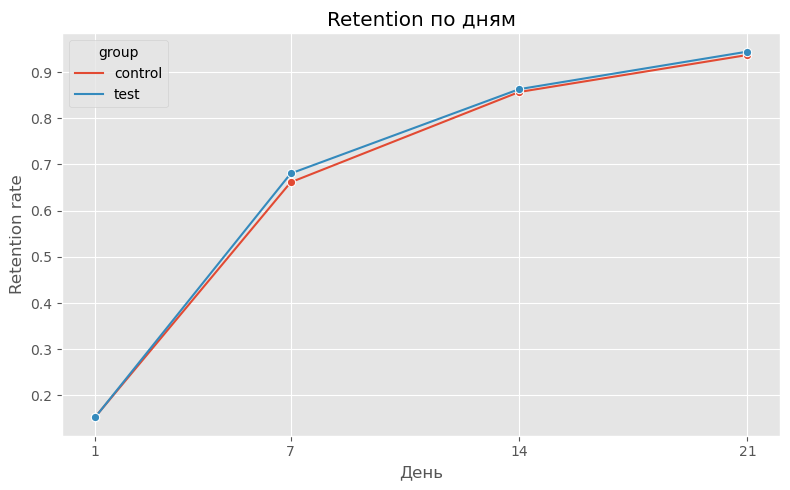

In [184]:
# Преобразование в long-format
retention_melted = experiment_df_retention.melt(
    id_vars='group',
    value_vars=['retention_1d', 'retention_7d', 'retention_14d', 'retention_21d'],
    var_name='day', value_name='retention'
)

# Группировка
retention_avg = retention_melted.groupby(['group', 'day'])['retention'].mean().reset_index()

# Преобразуем 'day' в числовой формат
retention_avg['day'] = retention_avg['day'].str.extract('(\d+)').astype(int)

# Построение графика
plt.figure(figsize=(8, 5))
sns.lineplot(data=retention_avg, x='day', y='retention', hue='group', marker='o')
plt.title("Retention по дням")
plt.xlabel("День")
plt.ylabel("Retention rate")
plt.xticks([1, 7, 14, 21])
plt.grid(True)
plt.tight_layout()
plt.show()

##### Средний чек (Average Order Value)

In [160]:
# Сколько денег в среднем приносит один заказ
# AOV = общая выручка / количество заказов

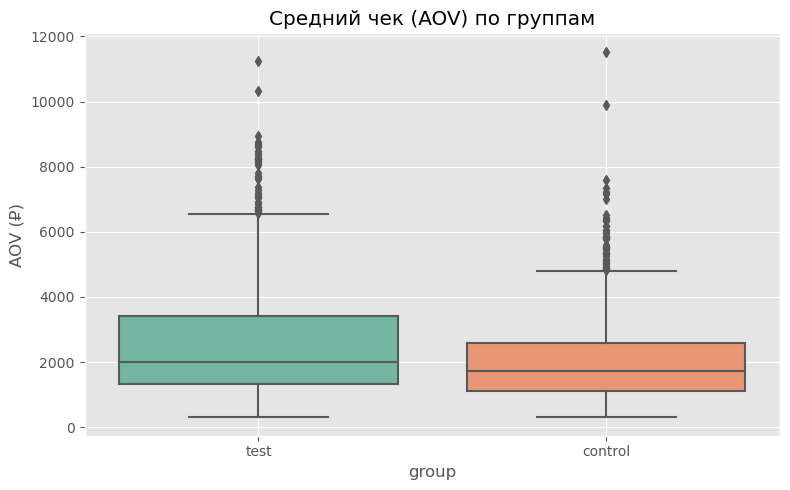

{'AOV (test)': 2517.58,
 'AOV (control)': 2026.67,
 'Uplift': 490.91,
 'T-statistic': 7.8983,
 'P-value': 0.0,
 'Significant': True}

In [226]:
# Шаг 1: Найдём пользователей с покупками и условный "чек"
# Допустим, каждая успешная покупка ('finish_pay') имеет случайный чек от 300 до 2000 рублей

# Добавим фиктивную стоимость покупок
np.random.seed(42)
events_df['order_value'] = events_df.apply(
    lambda row: np.random.randint(300, 2001) if row['event'] == 'finish_pay' else 0,
    axis=1
)

# Шаг 2: Присвоим каждой покупке группу (test/control)
push_campaign = campaign_interactions_df[campaign_interactions_df['campaign_id'] == 'push_abandon_cart']
test_users = push_campaign[['user_id', 'timestamp']].rename(columns={'timestamp': 'touch_time'})
control_users = control_group_df.rename(columns={'fake_touch_time': 'touch_time'})
test_users['group'] = 'test'
control_users['group'] = 'control'
experiment_df = pd.concat([test_users, control_users], ignore_index=True)

# Объединяем покупки с группой пользователей
events_with_group = events_df.merge(experiment_df, on='user_id', how='inner')

# Только оплаты
paid_events = events_with_group[events_with_group['event'] == 'finish_pay'].copy()

# Только те оплаты, что произошли после касания
paid_events = paid_events[paid_events['timestamp'] > paid_events['touch_time']]

# Группируем по пользователю и считаем сумму чека
user_aov = paid_events.groupby(['user_id', 'group'])['order_value'].sum().reset_index()


test_vals = user_aov[user_aov['group'] == 'test']['order_value']
control_vals = user_aov[user_aov['group'] == 'control']['order_value']

aov_test = test_vals.mean()
aov_control = control_vals.mean()
uplift = aov_test - aov_control
t_stat, p_value = ttest_ind(test_vals, control_vals, equal_var=False)

# Визуализация
plt.figure(figsize=(8, 5))
sns.boxplot(data=user_aov, x='group', y='order_value', palette='Set2')
plt.title("Средний чек (AOV) по группам")
plt.ylabel("AOV (₽)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Возвращаем сводку
{
    "AOV (test)": round(aov_test, 2),
    "AOV (control)": round(aov_control, 2),
    "Uplift": round(uplift, 2),
    "T-statistic": round(t_stat, 4),
    "P-value": round(p_value, 6),
    "Significant": p_value < 0.05
}

**Вывод**: средний чек в тесте выше, разница статистически значима

Визуализируем эти же данные иным способом:

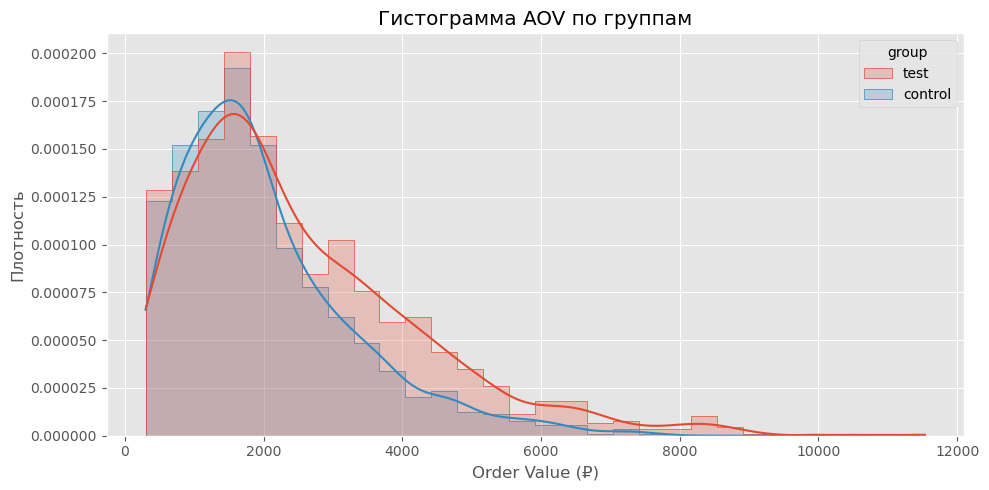

In [228]:
# 1. Гистограмма AOV по группам
plt.figure(figsize=(10, 5))
sns.histplot(data=user_aov, x='order_value', hue='group', kde=True, bins=30, element='step', stat='density')
plt.title("Гистограмма AOV по группам")
plt.xlabel("Order Value (₽)")
plt.ylabel("Плотность")
plt.grid(True)
plt.tight_layout()
plt.show()

Четко видим распределение значений чека. В тестовой группе средний чек явно выше. Распределение скошено вправо и имеет длинный хвост. Можно сделать вывод, что есть много людей с средним чеком, а также несколько пользователей с очень большой суммой заказов.

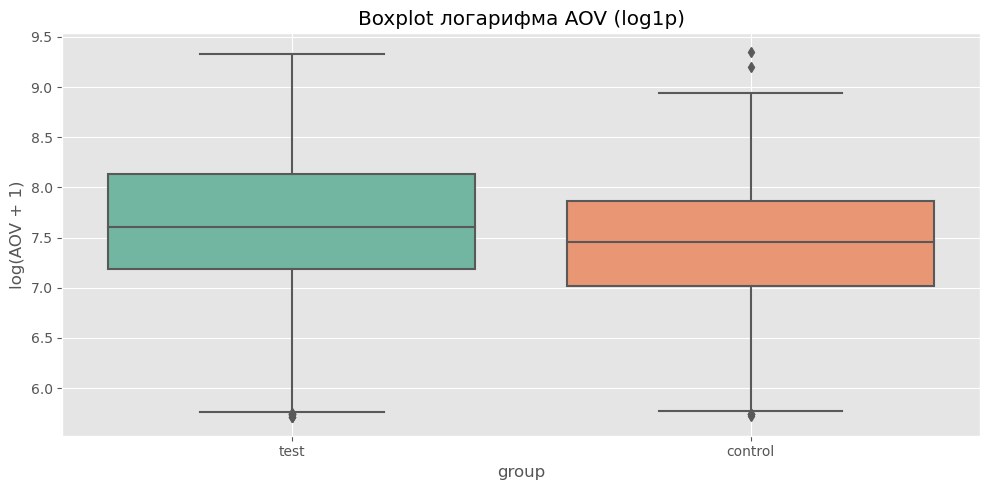

In [229]:
# 2. Логарифмированный AOV
user_aov['log_order_value'] = np.log1p(user_aov['order_value'])

plt.figure(figsize=(10, 5))
sns.boxplot(data=user_aov, x='group', y='log_order_value', palette='Set2')
plt.title("Boxplot логарифма AOV (log1p)")
plt.ylabel("log(AOV + 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

AOV обычно распределён не нормально — это right-skewed (есть много заказов с маленькими суммами и несколько супердорогих) как в нашем случае.

Логарифм «сжимает» большие значения и делает распределение ближе к нормальному.

log1p = log(x + 1) - защита от нуля, тк log(0) не существует, а log1p(0) = 0.

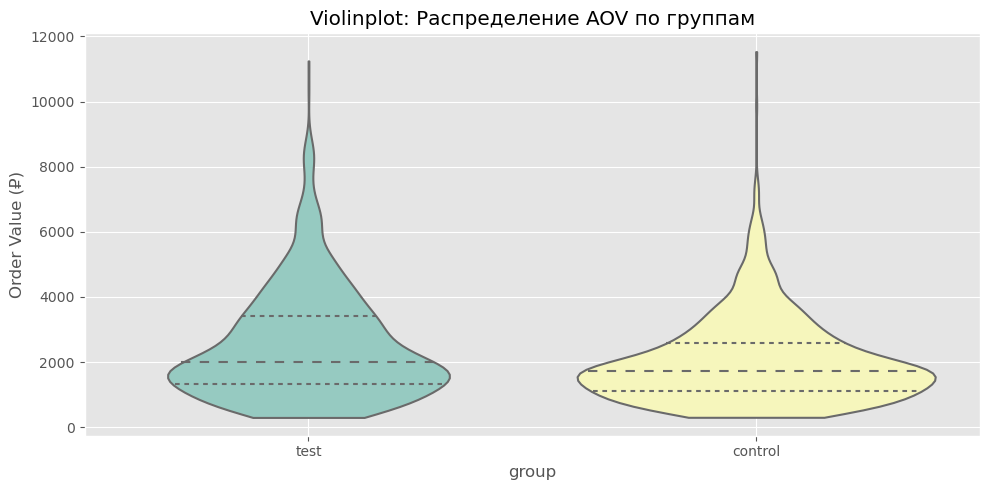

In [231]:
# 3. Violinplot — форма распределения
plt.figure(figsize=(10, 5))
sns.violinplot(data=user_aov, x='group', y='order_value', palette='Set3', inner='quartile', cut=0)
plt.title("Violinplot: Распределение AOV по группам")
plt.ylabel("Order Value (₽)")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Частота заказов (orders per user)

Буду считать эту метрику как количество заказов (finish_pay) после касания, делённое на количество пользователей в группе.

In [203]:
from scipy.stats import mannwhitneyu

# Получим события finish_pay
orders = events_df[events_df['event'] == 'finish_pay']

# Привяжем заказы к пользователям после касания
def get_orders_after_touch(user_id, touch_time):
    user_orders = orders[(orders['user_id'] == user_id) & (orders['timestamp'] > touch_time)]
    return len(user_orders)

experiment_df_fr = experiment_df.copy()
experiment_df_fr['orders'] = experiment_df_fr.apply(lambda row: get_orders_after_touch(row['user_id'], row['touch_time']), axis=1)

# Группировка и расчёт метрики
orders_summary = experiment_df_fr.groupby('group')['orders'].agg(['mean', 'median', 'std', 'count'])
print("\n=== Orders per User Summary ===")
print(orders_summary)

# Проведём статистический тест (Mann–Whitney U test, не предполагает нормальность)
test_orders = experiment_df_fr[experiment_df_fr['group'] == 'test']['orders']
control_orders = experiment_df_fr[experiment_df_fr['group'] == 'control']['orders']

stat, p = mannwhitneyu(test_orders, control_orders, alternative='two-sided')
print(f"\nMann–Whitney U test: U={stat:.2f}, p-value={p:.5f}")
if p < 0.05:
    print("Различие статистически значимо (p < 0.05)")
else:
    print("Нет статистически значимого различия (p ≥ 0.05)")


=== Orders per User Summary ===
             mean  median       std  count
group                                     
control  1.056433     1.0  1.168560   1772
test     1.585545     1.0  1.469038   1771

Mann–Whitney U test: U=1900024.00, p-value=0.00000
Различие статистически значимо (p < 0.05)


**Вывод:**

В тестовой группе средняя частота заказов = 1.5855, а в контрольной = 1.0564.

Test-группа в среднем совершает больше заказов: +0.53 заказа на пользователя (рост ~50%) \
Медиана в обеих группах = 1, что говорит о том, что большинство пользователей совершили всего один заказ \
Но хвост у тест-группы длиннее - это подтверждает большее std и среднее.

p-value < 0.05, следовательно, отвергаем нулевую гипотезу: различие между группами статистически значимо. Также использовала для проверки критерий Манна-Уитни, так как он не делает предположений о распределении (а мы имеем дискретную и скошенную метрику)

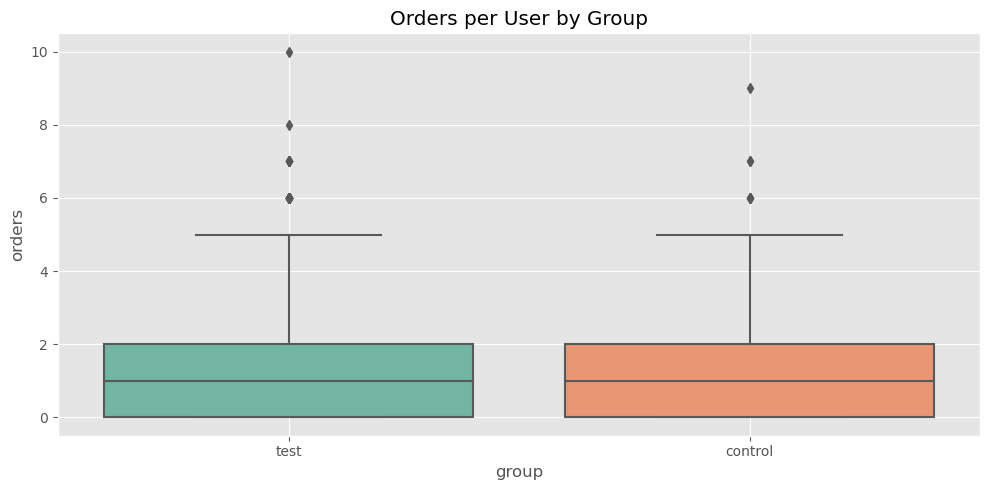

In [206]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=experiment_df_fr, x='group', y='orders', palette='Set2')
plt.title("Orders per User by Group")
plt.grid(True)
plt.tight_layout()
plt.show()

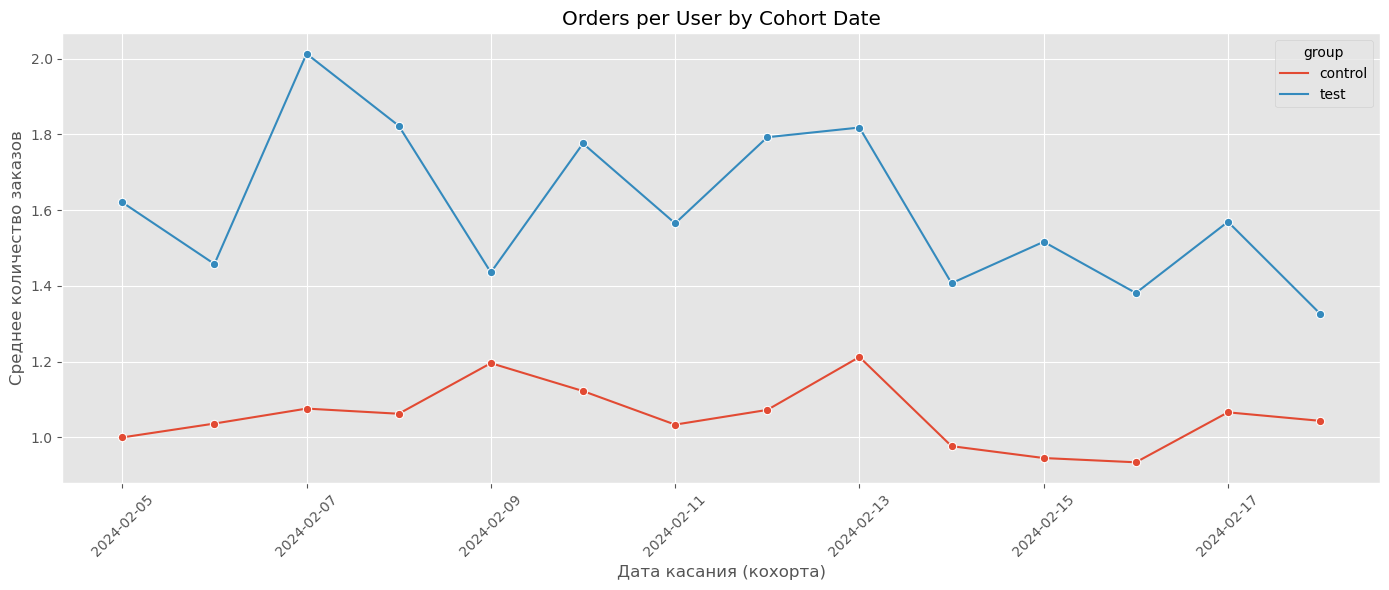

In [210]:
# Добавим колонку "cohort_date"
experiment_df_fr["cohort_date"] = experiment_df_fr["touch_time"].dt.date

# Среднее количество заказов по когортам
cohort_summary = experiment_df_fr.groupby(["cohort_date", "group"])["orders"].mean().reset_index()

# Визуализация
plt.figure(figsize=(14, 6))
sns.lineplot(data=cohort_summary, x="cohort_date", y="orders", hue="group", marker="o")
plt.title("Orders per User by Cohort Date")
plt.xlabel("Дата касания (кохорта)")
plt.ylabel("Среднее количество заказов")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Bootstrap-доверительный интервал для разницы средних

In [214]:
# Выделим выборки
test_orders = experiment_df_fr[experiment_df_fr['group'] == 'test']['orders'].values
control_orders = experiment_df_fr[experiment_df_fr['group'] == 'control']['orders'].values

# Bootstrap
np.random.seed(42)
boot_diffs = []

for _ in range(10000):
    sample_test = np.random.choice(test_orders, size=len(test_orders), replace=True)
    sample_control = np.random.choice(control_orders, size=len(control_orders), replace=True)
    # считаем разницу средних заказов на пользователя
    boot_diffs.append(sample_test.mean() - sample_control.mean())

# Интервал
lower, upper = np.percentile(boot_diffs, [2.5, 97.5])
mean_diff = np.mean(boot_diffs)

print(f"\nBootstrap CI for uplift (orders per user):")
print(f"Средняя разница: {mean_diff:.4f}")
print(f"95% доверительный интервал: [{lower:.4f}, {upper:.4f}]")

if lower > 0:
    print("Разница значима: uplift положительный")
elif upper < 0:
    print("Разница значима: uplift отрицательный")
else:
    print("Разница незначима (CI включает 0)")


Bootstrap CI for uplift (orders per user):
Средняя разница: 0.5288
95% доверительный интервал: [0.4410, 0.6172]
Разница значима: uplift положительный


**Вывод:**

1) В среднем, пользователи из тестовой группы совершают на ~0.53 заказа больше, чем пользователи из контрольной 
2) Уверены на 95%, что реальный uplift находится между ~0.44 и ~0.62 заказов на пользователя 
3) Интервал не включает 0, значит результат надёжный и не случайный.

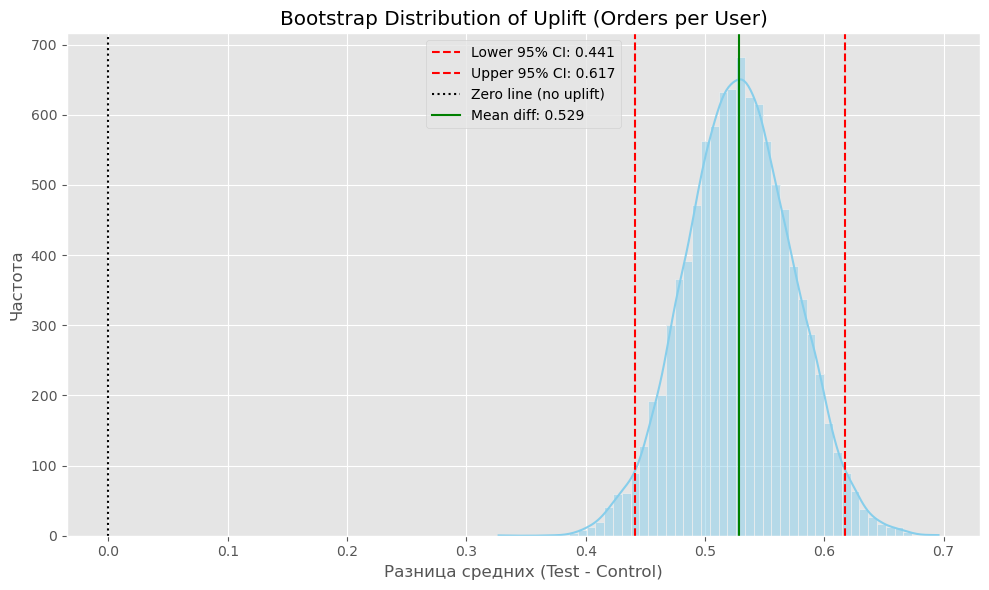

In [224]:
# Визуализация распределения разницы
plt.figure(figsize=(10, 6))
sns.histplot(boot_diffs, bins=50, kde=True, color='skyblue')
plt.axvline(x=lower, color='red', linestyle='--', label=f'Lower 95% CI: {lower:.3f}')
plt.axvline(x=upper, color='red', linestyle='--', label=f'Upper 95% CI: {upper:.3f}')
plt.axvline(x=0, color='black', linestyle=':', label='Zero line (no uplift)')
plt.axvline(x=mean_diff, color='green', linestyle='-', label=f'Mean diff: {mean_diff:.3f}')
plt.title("Bootstrap Distribution of Uplift (Orders per User)")
plt.xlabel("Разница средних (Test - Control)")
plt.ylabel("Частота")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

👩🏼‍💻Время до первого заказа

##### LTV (Lifetime Value) - общая сумма заказов пользователя после касания

In [238]:
# Функция расчёта LTV (после касания)
# LTV = сумма order_value (после касания)
orders = events_df[events_df['event'] == 'finish_pay']
def calc_ltv(user_id, touch_time):
    user_orders = orders[(orders['user_id'] == user_id) & (orders['timestamp'] > touch_time)]
    return user_orders['order_value'].sum()

experiment_df_ltv = experiment_df.copy()
experiment_df_ltv['ltv'] = experiment_df_ltv.apply(lambda row: calc_ltv(row['user_id'], row['touch_time']), axis=1)

# Сводка по LTV
ltv_summary = experiment_df_ltv.groupby('group')['ltv'].agg(['mean', 'median', 'std', 'count'])
print("\nLTV Summary:")
print(ltv_summary)

# Bootstrap-доверительный интервал
test_ltv = experiment_df_ltv[experiment_df_ltv['group'] == 'test']['ltv'].values
control_ltv = experiment_df_ltv[experiment_df_ltv['group'] == 'control']['ltv'].values

boot_diffs = []
np.random.seed(42)

for _ in range(10000):
    sample_test = np.random.choice(test_ltv, size=len(test_ltv), replace=True)
    sample_control = np.random.choice(control_ltv, size=len(control_ltv), replace=True)
    boot_diffs.append(sample_test.mean() - sample_control.mean())

lower, upper = np.percentile(boot_diffs, [2.5, 97.5])
mean_diff = np.mean(boot_diffs)

print(f"\nBootstrap CI for uplift (LTV):")
print(f"Средняя разница: {mean_diff:.2f} ₽")
print(f"95% доверительный интервал: [{lower:.2f} ₽, {upper:.2f} ₽]")

if lower > 0:
    print("Разница значима: uplift положительный")
elif upper < 0:
    print("Разница значима: uplift отрицательный")
else:
    print("Разница незначима (CI включает 0)")


LTV Summary:
                mean  median          std  count
group                                           
control  1222.635440   881.0  1430.489131   1772
test     1850.871824  1514.0  1831.430629   1771

Bootstrap CI for uplift (LTV):
Средняя разница: 627.83 ₽
95% доверительный интервал: [521.04 ₽, 735.99 ₽]
Разница значима: uplift положительный


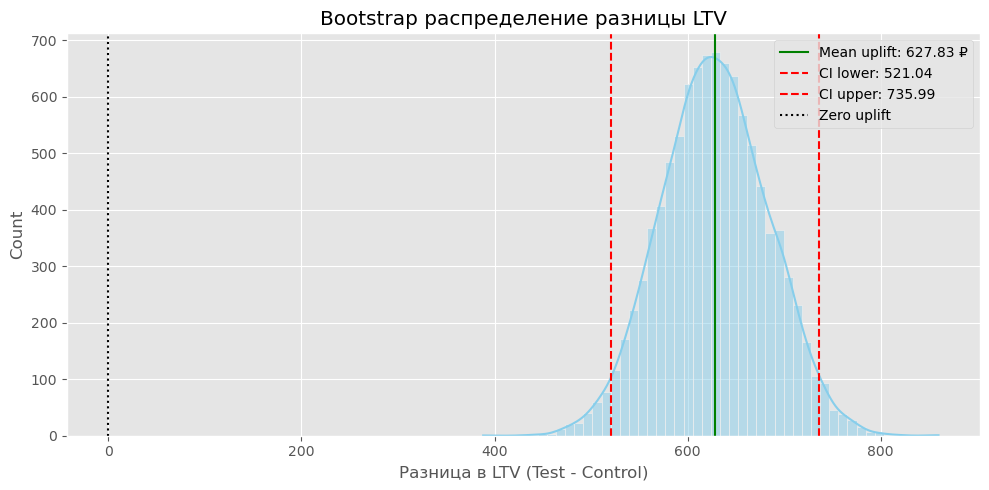

In [237]:
plt.figure(figsize=(10, 5))
sns.histplot(boot_diffs, bins=50, kde=True, color='skyblue')
plt.axvline(mean_diff, color='green', label=f"Mean uplift: {mean_diff:.2f} ₽")
plt.axvline(lower, color='red', linestyle='--', label=f"CI lower: {lower:.2f}")
plt.axvline(upper, color='red', linestyle='--', label=f"CI upper: {upper:.2f}")
plt.axvline(0, color='black', linestyle=':', label='Zero uplift')
plt.title("Bootstrap распределение разницы LTV")
plt.xlabel("Разница в LTV (Test - Control)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

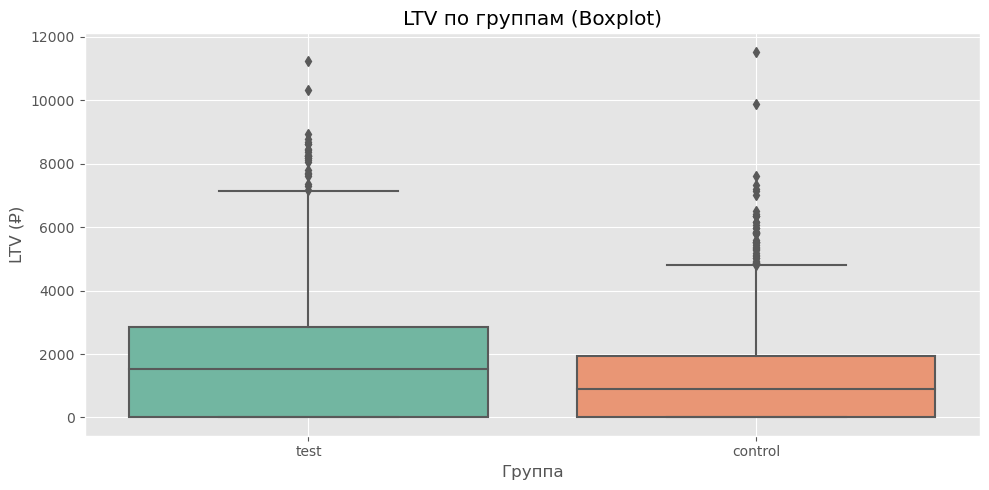

In [240]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=experiment_df_ltv, x='group', y='ltv', palette='Set2')
plt.title("LTV по группам (Boxplot)")
plt.ylabel("LTV (₽)")
plt.xlabel("Группа")
plt.grid(True)
plt.tight_layout()
plt.show()

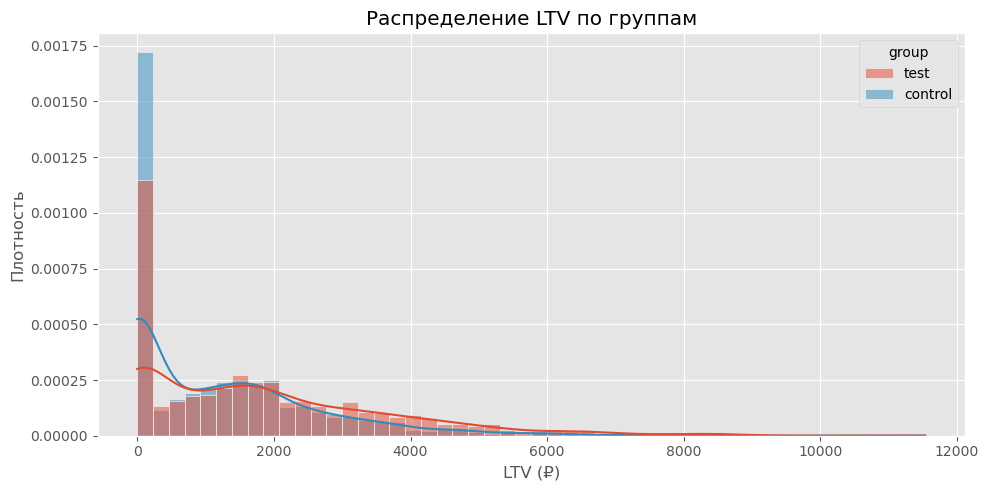

In [241]:
plt.figure(figsize=(10, 5))
sns.histplot(data=experiment_df_ltv, x='ltv', hue='group', bins=50, kde=True, stat="density", common_norm=False)
plt.title("Распределение LTV по группам")
plt.xlabel("LTV (₽)")
plt.ylabel("Плотность")
plt.grid(True)
plt.tight_layout()
plt.show()

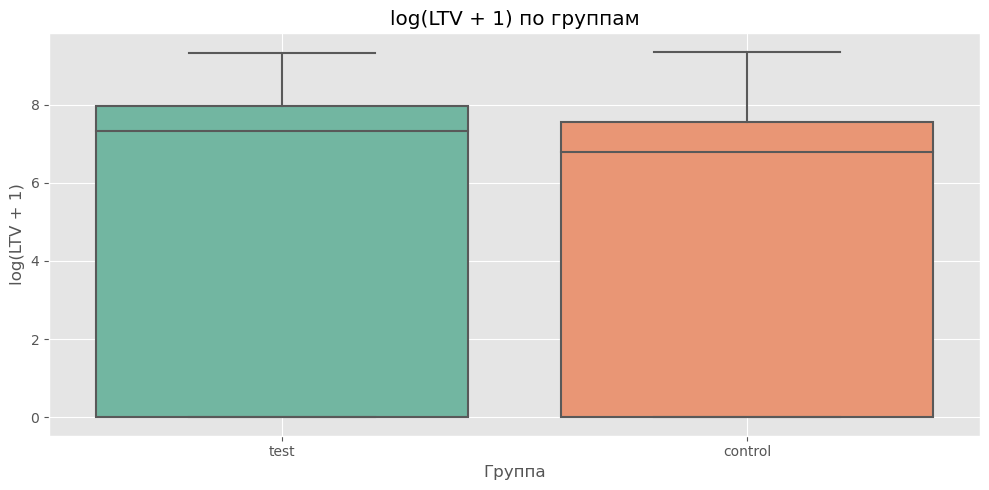

In [242]:
experiment_df_ltv['log_ltv'] = np.log1p(experiment_df_ltv['ltv'])  # log(ltv + 1)

plt.figure(figsize=(10, 5))
sns.boxplot(data=experiment_df_ltv, x='group', y='log_ltv', palette='Set2')
plt.title("log(LTV + 1) по группам")
plt.ylabel("log(LTV + 1)")
plt.xlabel("Группа")
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод:**

1) Средний LTV в тестовой группе на 627 ₽ выше, чем в контрольной.
2) Медиана тоже выше (1514 ₽ против 881 ₽) — значит, разница не только за счёт выбросов, но и в “основной массе” пользователей.
3) Стандартное отклонение немаленькое (будем счиатать, что это нормально для LTV, так как она часто сильно скошена).
4) Количество пользователей в группах почти одинаковое 

##### CTR (если пуш)

In [246]:
# Фильтруем только нужную кампанию
push_data = campaign_interactions_df[campaign_interactions_df['campaign_id'] == 'push_abandon_cart']

# Считаем общее количество отправок и кликов
total_sent = len(push_data)
total_clicked = (push_data['reaction'] == 'clicked').sum()

# CTR
ctr = total_clicked / total_sent

# Результат
print(f"Всего отправлено пушей: {total_sent}")
print(f"Кликнули: {total_clicked}")
print(f"CTR: {ctr:.4%}")

Всего отправлено пушей: 1771
Кликнули: 559
CTR: 31.5641%


На будущее добавить:

1) Посчитать CTR по платформам (iOS vs Android)
2) Посмотреть CTR по времени отправки или дням недели
3) Посчитать конверсию после клика (например, кто кликнул, а потом купил)

### Метрики

##### Retention D1, D3, D7, D14, D21: возвращаемость пользователей после первого визита

In [260]:
# Фильтруем только визиты
visits = events_df[events_df['event'] == 'open_app']

# Находим дату первого визита
first_visits = visits.groupby('user_id')['timestamp'].min().reset_index()
first_visits.columns = ['user_id', 'first_visit']

# Объединяем с полным логом, чтобы смотреть возвраты
visits = visits.merge(first_visits, on='user_id')

# Считаем количество уникальных дней после первого визита
visits['days_since_first'] = (visits['timestamp'].dt.date - visits['first_visit'].dt.date).dt.days

# Убираем первый день (сам визит)
retention_df = visits[visits['days_since_first'] > 0]

# Функция расчёта Retention Dn
def calc_retention(n):
    returned_users = retention_df[retention_df['days_since_first'] == n]['user_id'].nunique()
    total_users = first_visits['user_id'].nunique()
    return round(returned_users / total_users * 100, 2)

# Считаем Retention D1, D3, D7
ret_d1 = calc_retention(1)
ret_d3 = calc_retention(3)
ret_d7 = calc_retention(7)
ret_d14 = calc_retention(14)
ret_d21 = calc_retention(21)

print("Retention от первого визита:")
print(f"D1 Retention: {ret_d1}%")
print(f"D3 Retention: {ret_d3}%")
print(f"D7 Retention: {ret_d7}%")
print(f"D14 Retention: {ret_d14}%")
print(f"D21 Retention: {ret_d21}%")

Retention от первого визита:
D1 Retention: 14.82%
D3 Retention: 14.28%
D7 Retention: 14.2%
D14 Retention: 14.24%
D21 Retention: 14.46%


**Вывод:**
    
`Высокий D1 Retention — 14.8%`

Это отличный показатель — почти 15% пользователей возвращаются на следующий день после первого открытия приложения \
Говорит о сильном первом впечатлении: возможно - удобный интерфейс, интерес к продукту, возможно — вовлекающий контент

`Очень стабильный Retention на D3–D21`

Уровень удержания почти не снижается со временем — это очень редкая и позитивная картина \
Значит, возвращающиеся пользователи возвращаются регулярно \
Может быть признаком регулярной потребности (так как мы доставляем еду).  

В общем виде я бы сформулировала, что после первого визита ~14% пользователей становятся “живыми” — возвращаются снова и снова, начиная уже с D1 и на протяжении следующих 3 недель.

##### после первого заказа (анализ повторных покупок)

In [262]:
# Фильтруем только заказы
orders = events_df[events_df['event'] == 'finish_pay']

# Находим дату первого визита
first_orders = orders.groupby('user_id')['timestamp'].min().reset_index()
first_orders.columns = ['user_id', 'first_order']

# Объединяем с полным логом, чтобы смотреть возвраты
orders = orders.merge(first_orders, on='user_id')

# Считаем количество уникальных дней после первого заказа
orders['days_since_first'] = (orders['timestamp'].dt.date - orders['first_order'].dt.date).dt.days

# Убираем первый день (сам визит)
retention_df = orders[orders['days_since_first'] > 0]

# Функция расчёта Retention Dn
def calc_retention(n):
    returned_users = retention_df[retention_df['days_since_first'] == n]['user_id'].nunique()
    total_users = first_orders['user_id'].nunique()
    return round(returned_users / total_users * 100, 2)

# Считаем Retention D1, D3, D7
ret_d1 = calc_retention(1)
ret_d3 = calc_retention(3)
ret_d7 = calc_retention(7)
ret_d14 = calc_retention(14)
ret_d21 = calc_retention(21)

print("Retention от первого заказа:")
print(f"D1 Retention: {ret_d1}%")
print(f"D3 Retention: {ret_d3}%")
print(f"D7 Retention: {ret_d7}%")
print(f"D14 Retention: {ret_d14}%")
print(f"D21 Retention: {ret_d21}%")

Retention от первого заказа:
D1 Retention: 2.07%
D3 Retention: 1.63%
D7 Retention: 1.69%
D14 Retention: 1.15%
D21 Retention: 0.96%


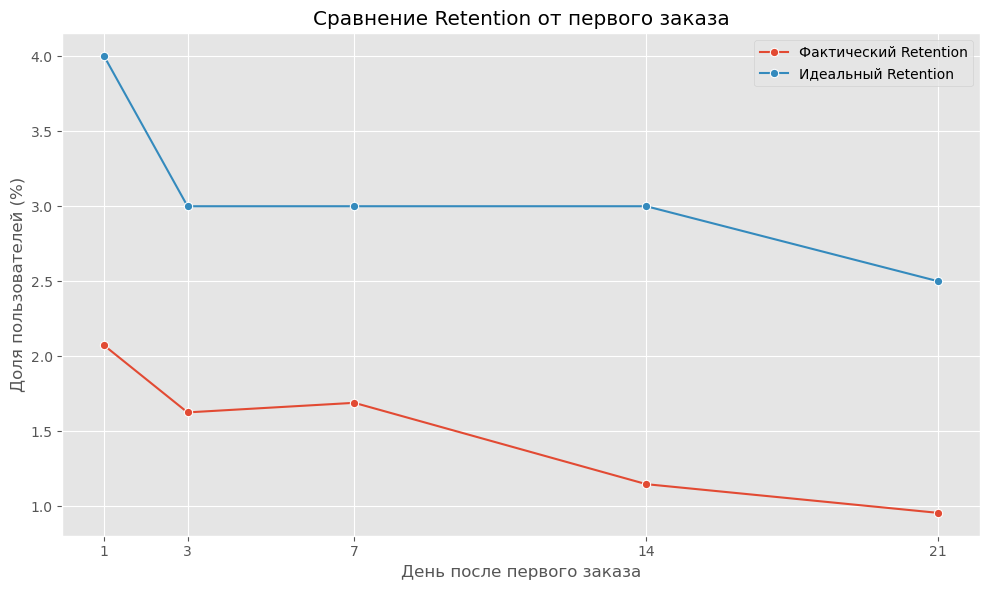

In [266]:
# Retention по дням
total_users = first_orders['user_id'].nunique()
retention_by_day = retention_df.groupby('days_since_first')['user_id'].nunique().reset_index()
retention_by_day['retention'] = (retention_by_day['user_id'] / total_users) * 100

# Только нужные дни
retention_actual = retention_by_day[retention_by_day['days_since_first'].isin([1, 3, 7, 14, 21])]

# Идеальные значения
ideal_retention = pd.DataFrame({
    'days_since_first': [1, 3, 7, 14, 21],
    'retention': [4, 3, 3, 3, 2.5]
})

# Визуализация
plt.figure(figsize=(10, 6))
sns.lineplot(data=retention_actual, x='days_since_first', y='retention', marker='o', label='Фактический Retention')
sns.lineplot(data=ideal_retention, x='days_since_first', y='retention', marker='o', label='Идеальный Retention')
plt.title("Сравнение Retention от первого заказа")
plt.xlabel("День после первого заказа")
plt.ylabel("Доля пользователей (%)")
plt.xticks([1, 3, 7, 14, 21])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Вывод:**

Не каждый пользователь готов сразу же купить второй раз через день, три или даже неделю.
Также логично, что многие пользователи возвращаются, но не сразу покупают — могут листать товары, сравнивать, ждать скидку. Поэтому retention по заказам всегда ниже, чем retention по open_app или другим событиям.

Также не стоит забывать о входных данных:

Сгенерированные данные имеют вероятность finish_pay в цепочке:

• У контрольной группы — 20% шанс, если дошёл до pay_page \
• У тестовой — 30%

плюс нет "реактивации" после первого заказа \
плюс нет подписочной модели


#### Avg. time to purchase: среднее время от открытия приложения до оплаты

Среднее время до покупки: 4.09 минут
Медианное время до покупки: 4.00 минут


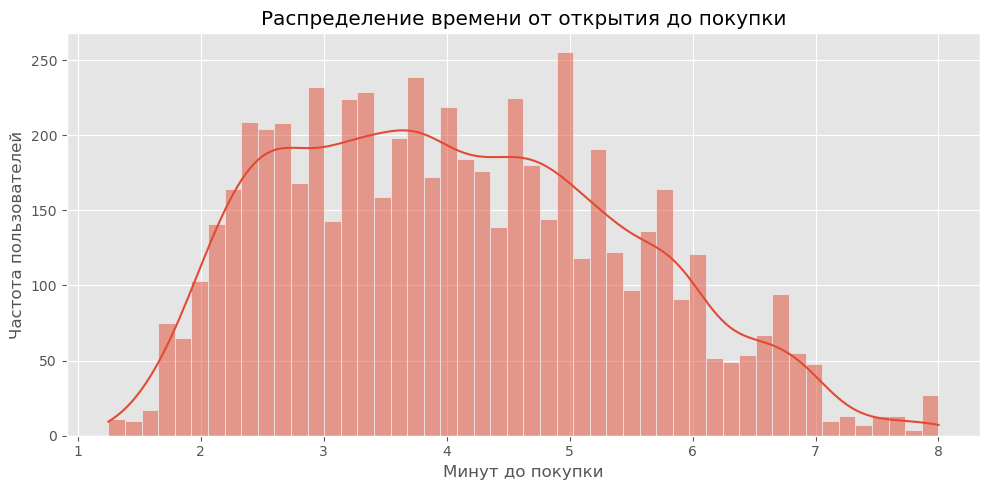

In [332]:
open_events = events_df[events_df['event'] == 'open_app']
pay_events = events_df[events_df['event'] == 'finish_pay']

open_pay_events = pd.concat([open_events, pay_events], ignore_index=True)

groupped_events = open_pay_events.groupby(['user_id', 'session_id'], as_index=False) \
                        .agg({'event':'nunique'}) \
                        .rename({'event':'events_cnt'}, axis=1)
session_ids_true = groupped_events[groupped_events['events_cnt'] > 1]

# оставляю записи, где в одной сессии есть open_app + finish_pay
avg_time_df = open_pay_events.merge(session_ids_true, on=['session_id', 'user_id'], \
                                    how='inner')

pivoted = avg_time_df.pivot_table(index = 'session_id', columns='event', 
                                  values='timestamp', aggfunc='min').reset_index()

pivoted['diff_time_min'] = (pivoted['finish_pay'].apply(lambda row: int(row.timestamp())) \
                        - pivoted['open_app'].apply(lambda row: int(row.timestamp()))) / 60

# Статистика
mean_time = pivoted['diff_time_min'].mean()
median_time = pivoted['diff_time_min'].median()

print("Среднее время до покупки: {:.2f} минут".format(mean_time))
print("Медианное время до покупки: {:.2f} минут".format(median_time))

plt.figure(figsize=(10, 5))
sns.histplot(pivoted['diff_time_min'], bins=50, kde=True)
plt.title("Распределение времени от открытия до покупки")
plt.xlabel("Минут до покупки")
plt.ylabel("Частота пользователей")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Session length: средняя длительность сессии

Средняя длительность сессии: 3.61 минут
Медианное время сессии: 3.47 минут


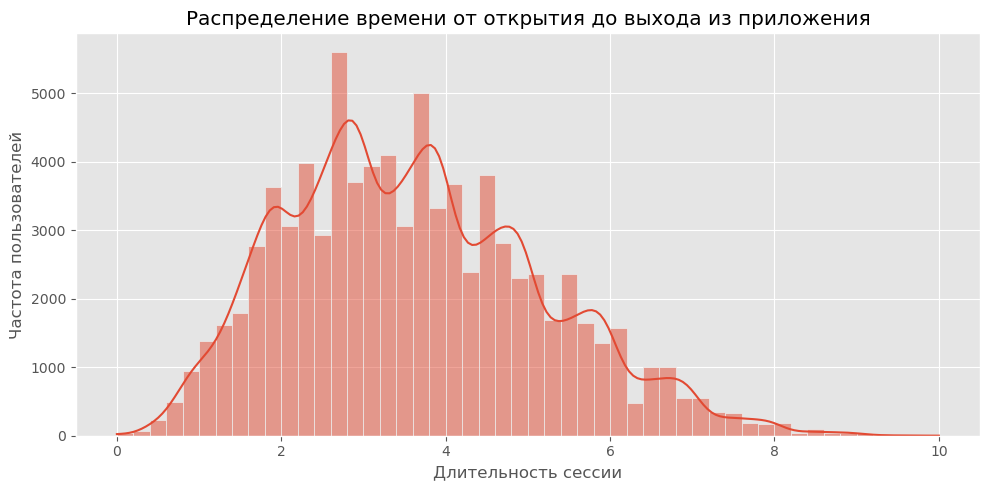

In [345]:
# рассчитаю min и max время для каждой сессии
sessions_df = events_df.groupby('session_id')['timestamp'].agg(['min', 'max']).reset_index() \
                            .rename({'min':'start_time', 'max':'end_time'}, axis=1)
# разница во времени для каждой сессии
sessions_df['diff_time_min'] = (sessions_df['end_time'].apply(lambda row: int(row.timestamp())) - \
                               sessions_df['start_time'].apply(lambda row: int(row.timestamp()))) / 60                           

# Статистика
mean_time = sessions_df['diff_time_min'].mean()
median_time = sessions_df['diff_time_min'].median()

print("Средняя длительность сессии: {:.2f} минут".format(mean_time))
print("Медианное время сессии: {:.2f} минут".format(median_time))

plt.figure(figsize=(10, 5))
sns.histplot(sessions_df['diff_time_min'], bins=50, kde=True)
plt.title("Распределение времени от открытия до выхода из приложения")
plt.xlabel("Длительность сессии")
plt.ylabel("Частота пользователей")
plt.grid(True)
plt.tight_layout()
plt.show()

#### ARPU (Average Revenue Per User)

In [347]:
# ARPU = Общая сумма выручки / Количество пользователей
# === Общий ARPU ===
total_revenue = events_df['order_value'].sum()
total_users = events_df['user_id'].nunique()

arpu = total_revenue / total_users
print(f"Общий ARPU: {arpu:.2f} ₽")

Общий ARPU: 1404.69 ₽


#### ARPPU (Average Revenue Per Paid User)

In [349]:
# ARPPU = Общая сумма выручки / Количество платящих пользователей
# === Общий ARPU ===
total_revenue = events_df['order_value'].sum()
total_paid_users = events_df[events_df['order_value'] > 0]['user_id'].nunique()

arpu = total_revenue / total_paid_users
print(f"Общий ARPPU: {arpu:.2f} ₽")

Общий ARPPU: 2239.63 ₽
